## Os últimos 1000 HCs impetrados no STJ que interessam ao MPSP
### 17/06/2022

O presente notebook buscou obter os resultados dos HCs impetrados no STJ.

A análise foi feita a partir de dataset composto dos últimos 1000 HCs impetrados no STJ. O arquivo "csv" foi gerado pelo STJ no dia 17 jun. 2022.

O codigo foi escrito em Python. Foram utilizadas as bibliotecas pandas (para as operações com o dataframe), matplotlib (para os gráficos), requests (para as requisições http ao site do STJ) e beautifulsoup (para a extração dos dados dos documentos html recuperados). A engine 'xlsxwriter' foi usada para gravar o arquivo Excel em unicode


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [2]:
df = pd.read_csv('processosSTJ_hc_todos_data_de_autuacao_1000.csv', 
                 parse_dates=['Data da Última Fase', 'Data Autuação'])

df = df.dropna(subset='Processo') # Exclusão dos registros sem o nº de processo.

print(f'Quantidade de processos no dataset: {len(df)}')
df.sample(3)

Quantidade de processos no dataset: 1000


,Número de Registro,Número Único,Processo,Nome Parte Autora,Nome Parte Ré,Data da Última Fase,Fase,Tramitando,Orgão Julgador,Segredo de Justiça,Ministro Relator,Observações,Data Autuação
119,202201858318,01858319820223000000,HC 749905,DEFENSORIA PÚBLICA DO ESTADO DE SÃO PAULO,TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO,2022-06-15 22:01:19+00:00,Conclusos para decisão ao(à) Ministro(a) JESUÍ...,S,QUINTA TURMA,N,JESUÍNO RISSATO (DESEMBARGADOR CONVOCADO DO TJ...,NaN,2022-06-15
204,202201835469,01835463520223000000,HC 749475,DEFENSORIA PÚBLICA DO ESTADO DE SÃO PAULO,TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO,2022-06-14 19:06:29+00:00,Conclusos para decisão ao(à) Ministro(a) REYNA...,S,QUINTA TURMA,N,REYNALDO SOARES DA FONSECA,NaN,2022-06-14
3,202201862405,01862407420223000000,HC 750113,CARLOS AGNALDO CARBONI,TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO,2022-06-15 18:15:37+00:00,Protocolizada Petição (originária) em 15/06/2022,S,NaN,N,NaN,NaN,2022-06-17


In [3]:
intervalo_autuacao = f"{str(df['Data Autuação'].min())[0:10]} a {str(df['Data Autuação'].max())[0:10]}"
print(f"Intervado das datas de autuação: {intervalo_autuacao}")
print(f"Total: {str(df['Data Autuação'].max() - df['Data Autuação'].min())[0:7]}")

Intervado das datas de autuação: 2022-06-07 a 2022-06-17
Total: 10 days


In [4]:
# Top 10 dos autores de HC:

autores = df['Nome Parte Autora'].value_counts()
autores.head(10)

DEFENSORIA PÚBLICA DO ESTADO DE SÃO PAULO    283
JOSE MAURICIO CAMARGO                         15
MATHEUS FERNANDO DA SILVA DOS SANTOS          14
BRUNO LEANDRO DIAS                            11
LARISSA CRISTINE SILVA PIERAZO                10
DEFENSORIA PÚBLICA DA UNIÃO                    9
VICTOR HUGO ANUVALE RODRIGUES                  9
DANIELLI DEL CISTIA                            8
KLEAN CINTRA PRADO                             6
FELIPE QUEIROZ GOMES                           6
Name: Nome Parte Autora, dtype: int64

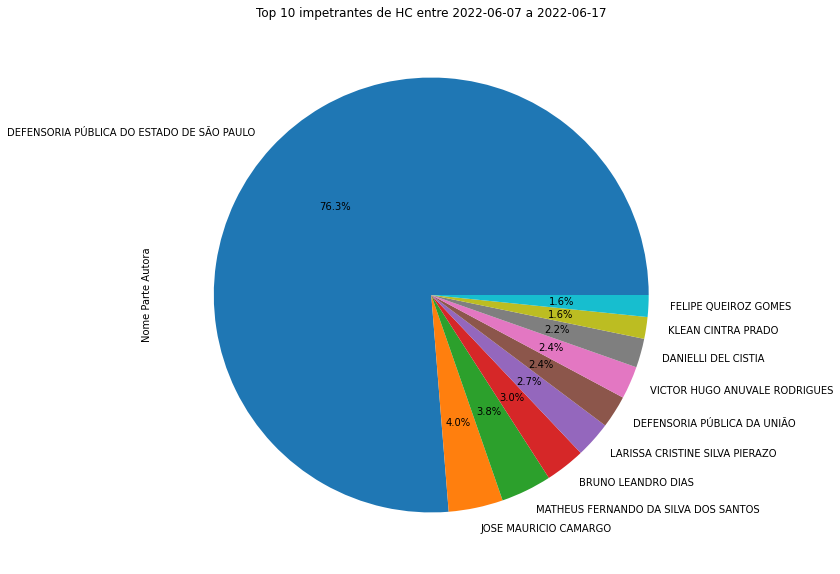

In [5]:
autores.head(10).plot.pie(title= f'Top 10 impetrantes de HC entre {intervalo_autuacao}', figsize=(12,10), autopct='%1.1f%%')
plt.savefig('hc.jpg')
plt.show()

In [6]:
# Preparação do dataframe para o webscraping

df['Número de Registro'] = df['Número de Registro'].astype(str)
df['Data da Última Fase'] = df['Data da Última Fase'].dt.tz_localize(None) # Remove timezone
df['Monocrática'] = ''
df['Acórdão'] = ''

# Funções 

def requisita_monocratica(registro):
    """Retorna o texto da decisão monocrática em para o registro fornecido"""
    response = requests.post(f'https://scon.stj.jus.br/SCON/pesquisar.jsp?livre={registro}&b=DTXT&p=true&tp=T')
    html = response.text # ver: https://stackoverflow.com/questions/17011357/what-is-the-difference-between-content-and-text 
    return html

def requisita_acordao(registro):
    """Retorna o texto do acórdao ou ementa para o registro fornecido"""
    response = requests.post(f'https://scon.stj.jus.br/SCON/pesquisar.jsp?livre={registro}&b=ACOR&p=true&tp=T')
    html = response.text # ver: https://stackoverflow.com/questions/17011357/what-is-the-difference-between-content-and-text 
    return html

def encontra_conteudo (html):
    """Retorna o conteúdo da id em formato texto e sem as tags do html"""
    soup = BeautifulSoup(html, 'html.parser')
    conteudo = soup.find(id="Semformatacao1") # com as tags
    return conteudo.text # sem as tags

In [7]:
# Percorrendo o dataframe

for i in df.index:
    registro = df.loc[i, 'Número de Registro']
    html = requisita_monocratica(registro)
    try:
        df.loc[i, 'Monocrática'] = encontra_conteudo(html)
    except:
        df.loc[i, 'Monocrática'] = 'Não encontrado'
    html = requisita_acordao(registro)
    try:
        df.loc[i, 'Acórdão'] = encontra_conteudo(html)
    except:
        df.loc[i, 'Acórdão'] = 'Não encontrado'

In [8]:
df.sample(5)

,Número de Registro,Número Único,Processo,Nome Parte Autora,Nome Parte Ré,Data da Última Fase,Fase,Tramitando,Orgão Julgador,Segredo de Justiça,Ministro Relator,Observações,Data Autuação,Monocrática,Acórdão
63,202201849319,01849311820223000000,HC 749801,DEFENSORIA PÚBLICA DO ESTADO DE SÃO PAULO,TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO,2022-06-17 11:32:32,Conclusos para decisão ao(à) Ministro(a) ANTON...,S,SEXTA TURMA,N,ANTONIO SALDANHA PALHEIRO,NaN,2022-06-15,Não encontrado,Não encontrado
354,202201816486,01816488420223000000,HC 749065,REJANE DINIZ DE OLIVEIRA,TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO,2022-06-17 11:30:54,Conclusos para decisão ao(à) Ministro(a) OLIND...,S,SEXTA TURMA,N,OLINDO MENEZES (DESEMBARGADOR CONVOCADO DO TRF...,NaN,2022-06-13,Não encontrado,Não encontrado
196,202201835077,01835073820223000000,HC 749576,MATHEUS EDUARDO RICORDI SANTAROSA,TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO,2022-06-17 11:32:04,Conclusos para decisão ao(à) Ministro(a) LAURI...,S,SEXTA TURMA,N,LAURITA VAZ,NaN,2022-06-14,Não encontrado,Não encontrado
814,202201771886,01771885420223000000,HC 748248,MAURICIO DE MELLO MARCHIORI,TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO,2022-06-15 18:36:01,Juntada de Petição de RECURSO ORDINÁRIO nº 514...,S,QUINTA TURMA,N,PRESIDENTE DO STJ,NaN,2022-06-08,\n\r\nHABEAS CORPUS Nº 748248 - SP (2022/01771...,Não encontrado
824,202201772900,01772907620223000000,HC 748268,DEFENSORIA PÚBLICA DO ESTADO DE SÃO PAULO,TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO,2022-06-15 18:41:00,Juntada de Petição de CIÊNCIA PELO MPF nº 5145...,S,SEXTA TURMA,N,ROGERIO SCHIETTI CRUZ,NaN,2022-06-08,\n\r\nHABEAS CORPUS Nº 748268 - SP (2022/01772...,Não encontrado


In [9]:
# Exportando o resultado para planilha Excel

df.to_excel('hc.xlsx', engine='xlsxwriter')

In [10]:
len(df)

1000

In [11]:
# HCs com decisões monocráticas ou acórdãos

criterio = (df['Monocrática'] != 'Não encontrado') | (df['Acórdão'] != 'Não encontrado')
df1 = df[criterio]
print(f"Total de HCs com decisões monocráticas ou acórdãos: {len(df1)}")

Total de HCs com decisões monocráticas ou acórdãos: 534


In [12]:
# Exportando o resultado para arquivo texto

with open ('hc.txt', 'w') as f:
    f.write(f"HABEAS CORPUS IMPETRADOS NO STJ ENTRE {intervalo_autuacao}\n\n")
    f.write(f"- Nº de HCs pesquisados: {len(df)}\n\n")
    f.write(f"Total de HCs com decisões monocráticas ou acórdãos: {len(df1)}\n\n")
    f.write("__________\n\n")
    
    for i in df1.index:
        f.write(f"Data Autuação: {df1['Data Autuação'][i]} - Processo: {df1['Processo'][i]}\n")
        f.write(f"Ministro Relator: {df1['Ministro Relator'][i]} - Órgão Julgador: {df1['Orgão Julgador'][i]}\n")
        f.write(f"Nome Parte Autora: {df1['Nome Parte Autora'][i]}\n")
        f.write(f"Nome Parte Ré: {df1['Nome Parte Ré'][i]}\n")
        f.write(f"Data da Última Fase: {str(df1['Data da Última Fase'][i])[0:10]}\n")
        f.write("__________\n\n")
        f.write(f"DECISÃO MONOCRÁTICA:\n{df1['Monocrática'][i]}\n\n")
        f.write(f"ACÓRDÃO:\n{df1['Acórdão'][i]}\n")
        f.write(f"\n**************** Fim dos dados do {df1['Processo'][i]} ****************\n\n")